In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import normalize
from scipy.sparse import dia_matrix
from scipy.optimize import minimize, shgo, dual_annealing, differential_evolution, basinhopping
import scipy

from sklearn.model_selection import train_test_split

import seaborn as sns

In [2]:
import json

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
path = "../data/data.xlsx"
df = pd.read_excel(path)
df.Дата = df.Дата.astype('datetime64[ns]')

In [5]:
features = [
#     ['intercept'],
#     ['intercept', 'Кривизна'],
#     ['intercept', 'Кривизна', 'Профиль пути'],
#     ['intercept', 'Кривизна', 'n_feature_1'],
#     ['intercept', 'Кривизна', 'n_feature_2'],
#     ['intercept', 'Кривизна', 'n_feature_3'],
#     ['intercept', 'Кривизна', 'Профиль пути', 'n_feature_3'],
    ['intercept', 'Кривизна', 'Профиль пути', 'n_feature_3', 'n_feature_2'],
    ['intercept', 'Профиль пути', 'n_feature_3', 'n_feature_2']
]

target = ['Количество сшедших вагонов']

In [6]:
class MLM():
    
    log_likelihood_fun = 0

    predict_fun = None
    
    optimization_method = shgo
    borders = 10 * [(-1000, 1000)]
    
    df = None
    spaces = None
    target = None
    
    count_of_param_fun = 0
    
    thetas_for_tex = []
    AICs_c_for_tex = []
    
    
    def __init__(self, df, spaces, target,
                log_likelihood_fun,
                optimization_method, borders, predict_fun,
                count_of_param_fun):
        self.log_likelihood_fun = log_likelihood_fun
        self.optimization_method = optimization_method
        self.borders = borders
        self.predict_fun = predict_fun
        self.count_of_param_fun = count_of_param_fun
        self.spaces = spaces
        self.target = target
        self.df = df
    
    
    def neg_log_likehood_fun(self, theta, X, y, lambda_index):
        return -self.log_likelihood_fun(theta, X, y, lambda_index)
    
    
    def calc_aic_c(self, logL, space) -> float:
        k = len(space)
        n = len(self.y)
        eps = 1e-3
        return round(2 * (k - logL) + 2 * k * (k + 1) / (n - k - 1 + eps), 2)
    
    
    def round_and_format_params(self, a, is_tex_output=False):
        if is_tex_output:
            result_str = ''
            for i in a:
                result_str += ('$%.2f$, ' % i)
            result_str = '[' + result_str[:-2] + ']'
            return result_str
        else:
            result = []
            for i in a:
                result.append(round(i, 2))
            return result
    
    
    def print_tex(self):
        print('\\newcommand{\\lambdasTab}{$\\lambda_i$}')
        print('\\newcommand{\\criteriaTab}{$AIC_c$}')
        print('\\newcommand{\\paramsTab}{$\\hat{\\theta}$}')
        print('\\newcommand{\\lenFirstColumnTab}{1.5cm}')
        print('\\begin{center}\n')
        space_ind = 0
        for space in self.spaces:
            space_ind += 1
            data = self.df[space + self.target].dropna()
            self.y = np.array(data[self.target])

            lambdas_str = ''
            for i in range(self.count_of_param_fun):
                lambdas_str += ' & $\\lambda_' + str(i + 1) + '$'
            
            print('\\resizebox{\\textwidth}{!}{')
            print('\t\\begin{tabular}{|p{\\lenFirstColumnTab}||' + 'p{4cm}|'*(self.count_of_param_fun) + '}')
            
            print('\t\t\\hline')
            print('\t\t$n = ' + str(len(self.y)) + '$ & \\multicolumn{' + str(self.count_of_param_fun) + '}{c|}{модели с признаковым пространством $features_' + str(space_ind) + '$} \\\\ \\hline\\hline')
            print('\t\t\\lambdasTab' + lambdas_str + ' \\\\ \\hline')
            print('\t\t\\criteriaTab & ' + str(self.AICs_c_for_tex[space_ind-1]) + ' \\\\ \\hline')
            print('\t\t\\paramsTab & ' + str(self.thetas_for_tex[space_ind-1]) + ' \\\\ \\hline')
            
            print('\t\\end{tabular}')
            print('}\n')
        print('\\end{center}')
    
    
    def fit_one(self, space, space_ind, link_fun_index):
        count_of_attempt = 0
        result = self.optimization_method(self.neg_log_likehood_fun,
                self.borders[:len(space)],
                args=(self.X, self.y, link_fun_index))#, maxiter=1500)

        while count_of_attempt < 20 and math.isnan(result['fun']):
            result = self.optimization_method(self.neg_log_likehood_fun,
                    self.borders[:len(space)],
                    args=(self.X, self.y, link_fun_index))#, maxiter=1500)
            count_of_attempt += 1
        if count_of_attempt == 20:
            print('count_of_attempt = 20')
        
        logL = round(-result['fun'], 2)
        AIC_c = self.calc_aic_c(logL, space)
        
        return {
            "space_id": space_ind-1,
            "link_fun_id": link_fun_index,
            "status": result['success'],
            "metrics": {
                "logL": logL,
                "AIC_c": AIC_c
            },
            "parameters": result['x']
        }
    
    
    def fit_all(self, print_result, print_tex_code):
        space_ind = 0
        results = []
        self.thetas_for_tex = []
        self.AICs_c_for_tex = []
        for space in self.spaces:
            space_ind += 1

            data = self.df[space + self.target].dropna()
            self.y = data[self.target]
            self.y = np.array(self.y)
            self.X = data.drop(self.target, axis=1)
            self.X = np.matrix(self.X)
            
            thetas_for_tex_line = ''
            AICs_c_for_tex_line = ''
            
            if print_result:
                print('Признаковое пространство', space_ind, ':', space)
                print('Мощность выборки n = ', len(self.y))
            
            for link_fun_index in range(self.count_of_param_fun):
                
                result = self.fit_one(space, space_ind, link_fun_index)
                
                if print_tex_code:
                    thetas_for_tex_line += self.round_and_format_params(result['parameters'], is_tex_output=True) + ' & '
                    AICs_c_for_tex_line += '$' + str(result['metrics']['AIC_c']) + '$' + ' & '
                
                result['parameters'] = self.round_and_format_params(result['parameters'])
                results.append(result)
                if print_result:
                    print(result)
            
            if print_result:
                print()
            
            if print_tex_code:
                self.thetas_for_tex.append(thetas_for_tex_line[:-3])
                self.AICs_c_for_tex.append(AICs_c_for_tex_line[:-3])
        
        if print_tex_code:
            self.print_tex()
        return json.dumps(results)
            
    # TO DO
    def predict(self, x_pred):
        return 0

Функция правдоподобия и короткая запись функций связи

In [104]:
lambdas = [
    (lambda t: np.exp(t)),
    (lambda t: np.exp(-t * t)),
    (lambda t: 1 + np.sqrt(np.abs(25 - (t-5)*(t-5)))),
    (lambda t: (t-1)*(t-1)),
    (lambda t: 1 / (1 + t*t)),
    (lambda t: t * (np.pi / 2.0 + np.arctan(-t)) + 1),
    (lambda t: np.log(1 + t*t) + 1),
]

def poisson_log_likelihood_function(theta, X, y, lambda_index):
    result = 0
    for i in range(len(y)):
        dot_prod = float(np.dot(X[i], theta))
        lambda_value = lambdas[lambda_index](dot_prod)
        log_lambda_value = np.log(lambdas[lambda_index](dot_prod))
        result -= np.log(scipy.special.factorial(y[i]))
        result += (float(y[i])) * log_lambda_value - lambda_value
    return result

In [88]:
lambdas_2 = [
    (lambda t: np.exp(t)),
    (lambda t: np.exp(-t * t)),
    (lambda t: 1 / (1 + np.exp(-t))),
    (lambda t: 1 / (1 + t*t)),
    (lambda t: t * (np.pi / 2.0 - np.arctan(-t)) + 1),
]

def geometry_log_likelihood_function(theta, X, y, lambda_index):
    result = 0
    for i in range(len(y)):
        dot_prod = float(np.dot(X[i], theta))
        lambda_value = lambdas_2[lambda_index](dot_prod)
        log_lambda_value = np.log(lambdas_2[lambda_index](dot_prod))
        result += (float(y[i])) * np.log(1 - lambdas_2[lambda_index](dot_prod)) + log_lambda_value
    return result

Функция правдоподобия и подробная запись функций связи

In [8]:
lambdas = [
    (lambda t: np.exp(t)),
    (lambda t: np.exp(-t * t)),
    (lambda t: 1 + np.sqrt(np.abs(25 - (t-5)*(t-5)))),
    (lambda t: (t-1)*(t-1)),
    (lambda t: 1 / (1 + t*t)),
    (lambda t: t * (np.pi / 2.0 + np.arctan(-t)) + 1),
    (lambda t: np.log(1 + t*t) + 1),
]

log_lambdas = [
    (lambda t: t),
    (lambda t: -t * t),
    (lambda t: np.log(1 + np.sqrt(np.abs(25 - (t-5)*(t-5))))),
    (lambda t: np.log((t-1)*(t-1))),
    (lambda t: -np.log(1 + t*t)),
    (lambda t: np.log(t * (np.pi / 2.0 + np.arctan(-t)) + 1)),
    (lambda t: np.log(np.log(1 + t*t) + 1)),
]

def poisson_log_likelihood_function(theta, X, y, lambda_index):
    result = 0
    for i in range(len(y)):
        dot_prod = float(np.dot(X[i], theta))
        lambda_value = lambdas[lambda_index](dot_prod)
        log_lambda_value = log_lambdas[lambda_index](dot_prod)
        result -= np.log(scipy.special.factorial(y[i])[0])
        result += (float(y[i])) * log_lambda_value - lambda_value
    return result

In [9]:
lambdas_2 = [
    (lambda t: np.exp(t)),
    (lambda t: np.exp(-t * t)),
    (lambda t: 1 / (1 + np.exp(-t))),
    (lambda t: 1 / (1 + t*t)),
    (lambda t: t * (np.pi / 2.0 - np.arctan(-t)) + 1),
]

log_lambdas_2 = [
    (lambda t: t),
    (lambda t: -t * t),
    (lambda t: -np.log(1 + np.exp(-t))),
    (lambda t: -np.log(1 + t*t)),
    (lambda t: np.log(t * (np.pi / 2.0 - np.arctan(-t)) + 1)),
]

log_one_minus_lambdas_2 = [
    (lambda t: np.log(1 - np.exp(t))),
    (lambda t: np.log(1 - np.exp(-t * t))),
    (lambda t: -np.log(1 + np.exp(t))),
    (lambda t: np.log(t*t) - np.log(1 + t*t)),
    (lambda t: np.log(-t * (np.pi / 2.0 - np.arctan(-t)))),
]

def geometry_log_likelihood_function(theta, X, y, lambda_index):
    result = 0
    for i in range(len(y)):
        dot_prod = float(np.dot(X[i], theta))
        lambda_value = lambdas_2[lambda_index](dot_prod)
        log_lambda_value = log_lambdas_2[lambda_index](dot_prod)
        result += (float(y[i])) * log_one_minus_lambdas_2[lambda_index](dot_prod) + log_lambda_value
    return result

Вычисление оценок

In [98]:
poisson_regressor = MLM(df, features, target,
                        poisson_log_likelihood_function,
                        dual_annealing, 10*[(-1000,1000)], None, len(lambdas))
poisson_regressor.fit_all(print_result=True, print_tex_code=True)

Признаковое пространство 1 : ['intercept', 'Кривизна']
Мощность выборки n =  46
{'status': True, 'metrics': {'logL': -231.34, 'AIC_c': 466.96}, 'parameters': [1.18, -271.63]}
{'status': True, 'metrics': {'logL': -281.73, 'AIC_c': 567.74}, 'parameters': [0.0, -0.03]}
{'status': True, 'metrics': {'logL': -231.46, 'AIC_c': 467.2}, 'parameters': [9.43, 367.47]}
{'status': True, 'metrics': {'logL': -231.21, 'AIC_c': 466.7}, 'parameters': [-0.8, 208.17]}
{'status': True, 'metrics': {'logL': -281.73, 'AIC_c': 567.74}, 'parameters': [-0.0, 0.12]}
{'status': True, 'metrics': {'logL': -241.09, 'AIC_c': 486.46}, 'parameters': [999.54, 593.81]}
{'status': True, 'metrics': {'logL': -231.73, 'AIC_c': 467.74}, 'parameters': [-2.66, 549.77]}

Признаковое пространство 2 : ['intercept', 'Кривизна', 'Профиль пути']
Мощность выборки n =  41
{'status': True, 'metrics': {'logL': -218.72, 'AIC_c': 444.09}, 'parameters': [1.17, -160.8, 39.3]}
{'status': True, 'metrics': {'logL': -271.03, 'AIC_c': 548.71}, 'pa

In [78]:
geometry_regressor = MLM(df, features, target,
                        geometry_log_likelihood_function,
                        dual_annealing, 10*[(-1000,1000)], None, len(lambdas_2))
geometry_regressor.fit_all(print_result=True, print_tex_code=True)

Признаковое пространство 1 : ['intercept', 'Кривизна']
Мощность выборки n =  46
{'status': True, 'metrics': {'logL': -98.07, 'AIC_c': 200.42}, 'parameters': [-1.46, 215.57]}
{'status': True, 'metrics': {'logL': -98.19, 'AIC_c': 200.66}, 'parameters': [-1.2, 90.37]}
{'status': True, 'metrics': {'logL': -98.21, 'AIC_c': 200.7}, 'parameters': [-1.18, 278.33]}
{'status': True, 'metrics': {'logL': -98.04, 'AIC_c': 200.36}, 'parameters': [-1.82, 233.2]}
{'status': True, 'metrics': {'logL': -98.01, 'AIC_c': 200.3}, 'parameters': [-0.95, 150.96]}

Признаковое пространство 2 : ['intercept', 'Кривизна', 'Профиль пути']
Мощность выборки n =  41
{'status': True, 'metrics': {'logL': -87.67, 'AIC_c': 181.99}, 'parameters': [-1.48, 218.05, -96.46]}
{'status': True, 'metrics': {'logL': -89.41, 'AIC_c': 185.47}, 'parameters': [1.23, -128.08, 33.41]}
{'status': True, 'metrics': {'logL': -89.44, 'AIC_c': 185.53}, 'parameters': [-1.27, 388.31, -103.96]}
{'status': True, 'metrics': {'logL': -85.97, 'AIC_c'

Вычисление тривиальных оценок

In [40]:
poisson_regressor = MLM(df, features, target,
                        poisson_log_likelihood_function,
                        dual_annealing, 10*[(-1000,1000)], None, len(lambdas))
poisson_regressor.fit_all(print_result=True, print_tex_code=True)

Признаковое пространство 1 : ['intercept']
Мощность выборки n =  56
{'status': True, 'metrics': {'logL': -274.6, 'AIC_c': 551.27}, 'parameters': [1.06]}
{'status': True, 'metrics': {'logL': -339.62, 'AIC_c': 681.31}, 'parameters': [-0.0]}
{'status': True, 'metrics': {'logL': -274.6, 'AIC_c': 551.27}, 'parameters': [9.64]}
{'status': True, 'metrics': {'logL': -274.6, 'AIC_c': 551.27}, 'parameters': [2.7]}
{'status': True, 'metrics': {'logL': -339.62, 'AIC_c': 681.31}, 'parameters': [-0.0]}
{'status': True, 'metrics': {'logL': -284.03, 'AIC_c': 570.13}, 'parameters': [998.2]}
{'status': True, 'metrics': {'logL': -274.6, 'AIC_c': 551.27}, 'parameters': [-2.35]}

\newcommand{\lambdasTab}{$\lambda_i$}
\newcommand{\criteriaTab}{$AIC_c$}
\newcommand{\paramsTab}{$\hat{\theta}$}
\newcommand{\lenFirstColumnTab}{1.5cm}
\begin{center}

\resizebox{\textwidth}{!}{
	\begin{tabular}{|p{\lenFirstColumnTab}||p{4cm}|p{4cm}|p{4cm}|p{4cm}|p{4cm}|p{4cm}|p{4cm}|}
		\hline
		$n = 56$ & \multicolumn{7}{c|}{мод

In [42]:
geometry_regressor = MLM(df, features, target,
                        geometry_log_likelihood_function,
                        dual_annealing, 10*[(-1000,1000)], None, len(lambdas_2))
geometry_regressor.fit_all(print_result=True, print_tex_code=True)

Признаковое пространство 1 : ['intercept']
Мощность выборки n =  56
{'status': True, 'metrics': {'logL': -123.91, 'AIC_c': 249.89}, 'parameters': [-1.35]}
{'status': True, 'metrics': {'logL': -123.91, 'AIC_c': 249.89}, 'parameters': [1.16]}
{'status': True, 'metrics': {'logL': -123.91, 'AIC_c': 249.89}, 'parameters': [-1.06]}
{'status': True, 'metrics': {'logL': -123.91, 'AIC_c': 249.89}, 'parameters': [-1.7]}
{'status': True, 'metrics': {'logL': -123.91, 'AIC_c': 249.89}, 'parameters': [-0.87]}

\newcommand{\lambdasTab}{$\lambda_i$}
\newcommand{\criteriaTab}{$AIC_c$}
\newcommand{\paramsTab}{$\hat{\theta}$}
\newcommand{\lenFirstColumnTab}{1.5cm}
\begin{center}

\resizebox{\textwidth}{!}{
	\begin{tabular}{|p{\lenFirstColumnTab}||p{4cm}|p{4cm}|p{4cm}|p{4cm}|p{4cm}|}
		\hline
		$n = 56$ & \multicolumn{5}{c|}{модели с признаковым пространством $features_1$} \\ \hline\hline
		\lambdasTab & $\lambda_1$ & $\lambda_2$ & $\lambda_3$ & $\lambda_4$ & $\lambda_5$ \\ \hline
		\criteriaTab & $249.89

In [5]:
json_test = {
    "1": {
        "first": 1,
        "second": "text"
    },
    "2": {
        "first": 2,
        "second": "text_2"
    }
}

print(json_test)

json_string = json.dumps(json_test)
print(json_string)
print(json_test["1"]["second"])

{'1': {'first': 1, 'second': 'text'}, '2': {'first': 2, 'second': 'text_2'}}
{"1": {"first": 1, "second": "text"}, "2": {"first": 2, "second": "text_2"}}
text


In [10]:
poisson_regressor = MLM(df, features, target,
                        poisson_log_likelihood_function,
                        dual_annealing, 10*[(-1000,1000)], None, len(lambdas))
poisson_regressor.fit_all(print_result=True, print_tex_code=False)

Признаковое пространство 1 : ['intercept', 'Кривизна', 'Профиль пути', 'n_feature_3', 'n_feature_2']
Мощность выборки n =  35
{'space_id': 1, 'link_fun_id': 0, 'status': True, 'metrics': {'logL': -172.4, 'AIC_c': 356.87}, 'parameters': [0.92, -105.42, 34.38, 0.02, -2.24]}
{'space_id': 1, 'link_fun_id': 1, 'status': True, 'metrics': {'logL': -255.28, 'AIC_c': 522.63}, 'parameters': [-0.31, 356.1, -105.08, 0.0, 0.02]}

Признаковое пространство 2 : ['intercept', 'Профиль пути', 'n_feature_3', 'n_feature_2']
Мощность выборки n =  37
{'space_id': 2, 'link_fun_id': 0, 'status': True, 'metrics': {'logL': -179.06, 'AIC_c': 367.37}, 'parameters': [0.55, 39.28, 0.03, -2.14]}
{'space_id': 2, 'link_fun_id': 1, 'status': True, 'metrics': {'logL': -261.07, 'AIC_c': 531.39}, 'parameters': [0.94, -5.3, -0.01, -0.8]}



'[{"space_id": 1, "link_fun_id": 0, "status": true, "metrics": {"logL": -172.4, "AIC_c": 356.87}, "parameters": [0.92, -105.42, 34.38, 0.02, -2.24]}, {"space_id": 1, "link_fun_id": 1, "status": true, "metrics": {"logL": -255.28, "AIC_c": 522.63}, "parameters": [-0.31, 356.1, -105.08, 0.0, 0.02]}, {"space_id": 2, "link_fun_id": 0, "status": true, "metrics": {"logL": -179.06, "AIC_c": 367.37}, "parameters": [0.55, 39.28, 0.03, -2.14]}, {"space_id": 2, "link_fun_id": 1, "status": true, "metrics": {"logL": -261.07, "AIC_c": 531.39}, "parameters": [0.94, -5.3, -0.01, -0.8]}]'

In [50]:
def predict_poisson(x_pred, theta, lambda_ind, k):
    dot_prod = float(np.dot(x_pred, theta))
    lambda_value = lambdas[lambda_ind](dot_prod)
    p_k = (lambda_value ** k) / (scipy.special.factorial(k)) * (np.exp(-lambda_value))
    return p_k

In [57]:
p = []
for i in range(0, 10, 1):
    p.append(predict_poisson(
        x_pred=[1.0, 0.001555, 0.001875, 58.356333, 0.684056],
        theta=[0.92, -105.33, 34.34, 0.02, -2.24], lambda_ind=0,
        k=i))
print(p)
print(sum(p))
print(np.argmax(p) + 1)

[0.2066212336961381, 0.32581440135634643, 0.25688314369303494, 0.13502359879102593, 0.05322859638154879, 0.016786893539312994, 0.004411785735751489, 0.0009938290760296254, 0.00019589215231220896, 3.4321784086802544e-05]
0.9999936962055874
2


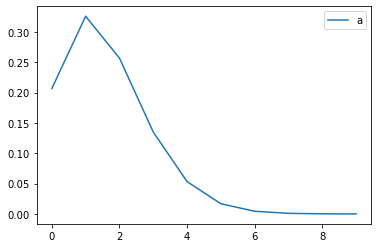

In [48]:
plt.plot(p, )
plt.legend()

In [54]:
def predict_geometry(x_pred, theta, lambda_ind, k):
    dot_prod = float(np.dot(x_pred, theta))
    p_value = lambdas_2[lambda_ind](dot_prod)
    p_k = ((1 - p_value) ** k) * p_value
    return p_k

In [56]:
p = []
for i in range(0, 10, 1):
    p.append(predict_geometry([1, 0.001555, 0.001875, 58.356333, 0.684056], [-2.01, 29.36, 226.20, -0.03, 3.85], 3, i))
print(p)
print(sum(p))
print(np.argmax(p) + 1)

[0.6983063803362838, 0.21067457951792115, 0.06355917646589304, 0.01917539801084016, 0.0057850952343827915, 0.001745326321360259, 0.0005265538153855349, 0.00015885792651140223, 4.792642286149757e-05, 1.4459095990619079e-05]
0.9999937531474301
1
